In [12]:
import numpy as np
import pandas as pd
import xarray as xr
from xarray.coding.calendar_ops import convert_calendar
!pip install xsdba
from xsdba.adjustment import QuantileDeltaMapping as QDM

# ----------------
# Configuration
# ----------------
CITIES = ["jeddah", "riyadh"]
MODELS = ["ACCESS-CM2", "EC-Earth3", "MPI-ESM1-2-HR"]
SCENARIOS = ["ssp126", "ssp245", "ssp585"]

ERA5_FILE = "era5_land_{city}_1985_2014_noleap.nc"  # var: t2m, dims: time, latitude, longitude
CMIP_HIST_FILE = "cmip6_tasmin_cities/{model}_tasmin_historical_1985_2014_{city}.nc"
CMIP_FUT_FILE = "cmip6_tasmin_cities/{model}_tasmin_{scenario}_2070_2100_{city}.nc"

OBS_VAR = "t2m"       # ERA5 variable you’re using (3AM local, near-min as you noted)
MOD_VAR = "tasmin"    # CMIP6 variable

TRAIN_START = "1985-01-01"
TRAIN_END   = "2014-12-31"
FUT_START   = "2070-01-01"
FUT_END     = "2100-12-31"

NQUANT = 50
GROUP = "time.month"  # monthly groups
KIND = "+"            # change-preserving (additive) for temperature anomalies
CDD_BASE = 20.0       # °C (keep consistent with your report)

# -------------
# Utilities
# -------------
def _to_degC(da: xr.DataArray) -> xr.DataArray:
    """Convert Kelvin->°C if units or values suggest Kelvin."""
    try:
        units = (da.attrs.get("units") or "").lower()
        if "k" == units or "kelvin" in units or float(da.max()) > 100:
            da = da - 273.15
            da.attrs["units"] = "degC"
        elif "c" in units:
            da.attrs["units"] = "degC"
        else:
            # If unknown but values are reasonable, set degC
            da.attrs.setdefault("units", "degC")
    except Exception:
        pass
    return da

def _ensure_noleap(da: xr.DataArray) -> xr.DataArray:
    """Convert to noleap calendar if needed."""
    try:
        cal = getattr(da.time.dt, "calendar", None)
        if cal and cal != "noleap":
            da = convert_calendar(da, "noleap")
    except Exception:
        # If .dt fails (object dtype), try decode then convert
        try:
            da = xr.decode_cf(da.to_dataset(name="var")).to_array().squeeze("variable", drop=True)
            cal = getattr(da.time.dt, "calendar", None)
            if cal and cal != "noleap":
                da = convert_calendar(da, "noleap")
        except Exception:
            pass
    return da

def _slice_time(da: xr.DataArray, start: str, end: str) -> xr.DataArray:
    return da.sel(time=slice(start, end))

def _align_hist_to_obs(obs: xr.DataArray, hist: xr.DataArray) -> xr.DataArray:
    """Align historical model to observation time (nearest), same calendar & period."""
    hist = _ensure_noleap(hist)
    hist = _slice_time(hist, TRAIN_START, TRAIN_END)
    # Align to ERA5 reference timeline (safe for historical only)
    hist = hist.reindex(time=obs.time, method="nearest")
    return hist

def _prepare_future(fut: xr.DataArray) -> xr.DataArray:
    """Keep future calendar & time native (NO reindex to obs)."""
    fut = _ensure_noleap(fut)
    fut = _slice_time(fut, FUT_START, FUT_END)
    return fut

def _load_era5_city(city: str) -> xr.DataArray:
    ds = xr.open_dataset(ERA5_FILE.format(city=city))
    da = ds[OBS_VAR]
    # Your original code took a spatial mean over latitude/longitude:
    if {"latitude", "longitude"}.issubset(set(da.dims)):
        da = da.mean(["latitude", "longitude"])
    da = _to_degC(da)
    da = _ensure_noleap(da)
    da = _slice_time(da, TRAIN_START, TRAIN_END)  # make sure it matches training window
    da.attrs.setdefault("long_name", f"ERA5 {OBS_VAR} (city mean)")
    return da

def _load_cmip_city_hist(model: str, city: str) -> xr.DataArray:
    ds = xr.open_dataset(CMIP_HIST_FILE.format(model=model, city=city))
    da = ds[MOD_VAR]
    # City files should already be a point; squeeze any leftover dims
    da = da.squeeze(drop=True)
    da = _to_degC(da)
    return da

def _load_cmip_city_future(model: str, scenario: str, city: str) -> xr.DataArray:
    ds = xr.open_dataset(CMIP_FUT_FILE.format(model=model, scenario=scenario, city=city))
    da = ds[MOD_VAR]
    da = da.squeeze(drop=True)
    da = _to_degC(da)
    return da

def _rmse(a: xr.DataArray, b: xr.DataArray) -> float:
    return float(np.sqrt(((a - b) ** 2).mean().values))

def _mae(a: xr.DataArray, b: xr.DataArray) -> float:
    return float(np.abs(a - b).mean().values)

def _bias(a: xr.DataArray, b: xr.DataArray) -> float:
    # bias of model vs obs (model - obs)
    return float((a - b).mean().values)

def _corr(a: xr.DataArray, b: xr.DataArray) -> float:
    try:
        return float(xr.corr(a, b).values)
    except Exception:
        # fallback
        aa = np.asarray(a.values).ravel()
        bb = np.asarray(b.values).ravel()
        if aa.size < 2 or bb.size < 2:
            return np.nan
        return float(np.corrcoef(aa, bb)[0, 1])

def _cdd(series_c: xr.DataArray, base: float = CDD_BASE) -> float:
    # Sum of (T - base)+ over the entire period
    pos = xr.where(series_c > base, series_c - base, 0.0)
    return float(pos.sum().values)

# ------------------------
# Core QDM runner (single)
# ------------------------
def run_qdm_analysis(era5_data: xr.DataArray,
                     cmip6_hist: xr.DataArray,
                     cmip6_future: xr.DataArray,
                     city_name: str,
                     variable_name: str = "temperature",
                     nquantiles: int = NQUANT) -> tuple[QDM, dict]:
    """
    Train QDM on ERA5 vs CMIP historical (1985–2014), then apply to historical & future (2070–2100).
    Returns (trained_adjuster, results_dict)
    """

    print(f" Starting QDM analysis for {city_name}...")
    print("=" * 60)

    # --- Prepare & align
    print(f" Preparing data for {city_name}...")
    print(f"    ERA5 raw: {str(era5_data.time.values[0])[:10]} → {str(era5_data.time.values[-1])[:10]} "
          f"({era5_data.time.size} days)")
    era5 = era5_data

    # Historical to noleap + alignment to ERA5 time
    hist = _align_hist_to_obs(era5, cmip6_hist)
    print(f"    Hist aligned: {str(hist.time.values[0])[:10]} → {str(hist.time.values[-1])[:10]} "
          f"({hist.time.size} days)")

    # Future: keep native 2070–2100, do NOT reindex to obs
    fut = _prepare_future(cmip6_future)
    print(f"    Future native: {str(fut.time.values[0])[:10]} → {str(fut.time.values[-1])[:10]} "
          f"({fut.time.size} days)")

    # Ranges
    try:
        print(f"    ERA5 range: {float(era5.min()):.1f} to {float(era5.max()):.1f}°C")
        print(f"    Hist range: {float(hist.min()):.1f} to {float(hist.max()):.1f}°C")
        print(f"    Future raw range: {float(fut.min()):.1f} to {float(fut.max()):.1f}°C")
    except Exception:
        pass

    # --- Train QDM
    print(f"\n Training QDM with {nquantiles} quantiles (group={GROUP}, kind={KIND})...")
    adjuster = QDM.train(ref=era5, hist=hist, nquantiles=nquantiles, kind=KIND, group=GROUP)
    print(f"    QDM training completed")

    # --- Apply to historical & future
    print("\n Applying QDM correction...")
    hist_corr = adjuster.adjust(hist, interp="linear")
    fut_corr = adjuster.adjust(fut, interp="linear")
    print("    Historical correction done")
    print("    Future projection corrected")

    # --- Evaluate (historical period only)
    print("\n Evaluating QDM performance (historical)...")
    rmse_before = _rmse(hist, era5)
    rmse_after = _rmse(hist_corr, era5)
    mae_before = _mae(hist, era5)
    mae_after = _mae(hist_corr, era5)
    bias_before = _bias(hist, era5)
    bias_after = _bias(hist_corr, era5)
    r_after = _corr(hist_corr, era5)

    perf = {
        "rmse_before": rmse_before,
        "rmse_after": rmse_after,
        "rmse_improvement": (1 - rmse_after / rmse_before) * 100 if rmse_before > 0 else np.nan,
        "mae_before": mae_before,
        "mae_after": mae_after,
        "mae_improvement": (1 - mae_after / mae_before) * 100 if mae_before > 0 else np.nan,
        "bias_before": bias_before,
        "bias_after": bias_after,
        "bias_improvement": (1 - abs(bias_after) / (abs(bias_before) + 1e-12)) * 100,
        "corrected_correlation": r_after,
    }

    for k, v in perf.items():
        if isinstance(v, float):
            perf[k] = float(v)

    print(f"    RMSE before/after: {rmse_before:.3f} → {rmse_after:.3f} (Δ {perf['rmse_improvement']:.1f}%)")
    print(f"    MAE before/after: {mae_before:.3f} → {mae_after:.3f} (Δ {perf['mae_improvement']:.1f}%)")
    print(f"    Bias before/after: {bias_before:.3f} → {bias_after:.3f} (Δ {perf['bias_improvement']:.1f}%)")
    print(f"    Corr (corrected vs ERA5): r={r_after:.3f}")

    # --- Indicators (CDD from series in °C)
    print("\n Calculating climate indicators (CDD base {:.1f}°C)...".format(CDD_BASE))
    indic = {
        "obs_cdd": _cdd(era5, base=CDD_BASE),
        "hist_corrected_cdd": _cdd(hist_corr, base=CDD_BASE),
        "future_cdd": _cdd(fut_corr, base=CDD_BASE),
        "obs_p95": float(era5.quantile(0.95).values),
        "hist_corrected_p95": float(hist_corr.quantile(0.95).values),
        "future_p95": float(fut_corr.quantile(0.95).values),
    }

    print(f"    CDD - Obs: {indic['obs_cdd']:.0f}, Hist-corr: {indic['hist_corrected_cdd']:.0f}, "
          f"Future: {indic['future_cdd']:.0f}")
    print(f"    P95 - Obs: {indic['obs_p95']:.1f}°C, Hist-corr: {indic['hist_corrected_p95']:.1f}°C, "
          f"Future: {indic['future_p95']:.1f}°C")

    print("\n QDM analysis completed successfully!")
    print("=" * 60)

    results = {"performance": perf, "indicators": indic, "hist_corrected": hist_corr, "future_corrected": fut_corr}
    return adjuster, results

# ----------------------------
# Data loading helper bundles
# ----------------------------
def load_and_prepare_era5():
    """Load ERA5 for both cities (as in your original)."""
    print(" Loading ERA5 datasets...")
    data = {}
    for city in CITIES:
        da = _load_era5_city(city)
        data[f"era5_{city}"] = da
        print(f"    {city.title()}: {da.shape} points, {int(da.time.dt.year.min())}-{int(da.time.dt.year.max())}")
    return data

def load_cmip6_city_series():
    """Load CMIP6 tasmin time series for all models/scenarios/cities (city-point files)."""
    print(" Loading CMIP6 city datasets...")
    out = {city: {} for city in CITIES}
    for city in CITIES:
        for model in MODELS:
            out[city].setdefault(model, {})
            # historical
            try:
                hist = _load_cmip_city_hist(model, city)
                out[city][model]["historical"] = hist
                print(f"    {model} {city} historical: {hist.shape}")
            except Exception as e:
                print(f"    {model} {city} historical: {e}")
                continue
            # futures
            for scenario in SCENARIOS:
                try:
                    fut = _load_cmip_city_future(model, scenario, city)
                    out[city][model][scenario] = fut
                    print(f"    {model} {city} {scenario}: {fut.shape}")
                except Exception as e:
                    print(f"    {model} {city} {scenario}: {e}")
    return out

# -------------------------
# Run all combinations
# -------------------------
def run_qdm_for_all():
    era5_data = load_and_prepare_era5()
    cmip_data = load_cmip6_city_series()

    summary = {}
    for city in CITIES:
        print("\n" + "=" * 60)
        print(f"  STARTING QDM ANALYSIS FOR {city.upper()}")
        print("=" * 60)
        summary[city] = {}
        era5_city = era5_data[f"era5_{city}"]

        for model in MODELS:
            print(f"\n Processing model: {model}")
            if "historical" not in cmip_data[city].get(model, {}):
                print("    No historical data; skipping model.")
                continue
            hist = cmip_data[city][model]["historical"]
            summary[city][model] = {}

            for scenario in SCENARIOS:
                print(f"\n Scenario: {scenario}")
                if scenario not in cmip_data[city][model]:
                    print(f"    No {scenario} data; skipping scenario.")
                    continue

                fut = cmip_data[city][model][scenario]
                try:
                    adj, res = run_qdm_analysis(
                        era5_data=era5_city,
                        cmip6_hist=hist,
                        cmip6_future=fut,
                        city_name=f"{city.title()} - {model} - {scenario.upper()}",
                        variable_name="minimum_temperature",
                        nquantiles=NQUANT
                        )

                    # Pre-compute monthly climatologies (cached for plotting)
                    def _m(da):  # monthly mean helper
                        return da.groupby("time.month").mean("time")

                    res["obs"]             = era5_city
                    res["hist_raw"]        = hist
                    res["future_raw"]      = fut
                    res["monthly"] = {
                        "obs":           _m(era5_city),
                        "hist_raw":      _m(hist),
                        "hist_corrected":_m(res["hist_corrected"]),
                        "future_raw":    _m(fut),
                        "future_corrected": _m(res["future_corrected"]),
                    }

                    # KEEP EVERYTHING for plotting later
                    summary[city][model][scenario] = res

                    print("    QDM completed successfully!")
                    print(f"    RMSE improvement: {res['performance']['rmse_improvement']:.1f}%")
                    print(f"    Bias improvement: {res['performance']['bias_improvement']:.1f}%")
                    print(f"     Future CDD: {res['indicators']['future_cdd']:.0f}")

                except Exception as e:
                    print(f"   ❌ QDM failed: {e}")
                    continue
    return summary

# -------------------------
# Summary table (like yours)
# -------------------------
def create_summary_table(results_summary: dict) -> pd.DataFrame | None:
    print("\n" + "=" * 80)
    print(" QDM PERFORMANCE SUMMARY")
    print("=" * 80)

    rows = []
    for city, mdict in results_summary.items():
        for model, sdict in mdict.items():
            for scenario, res in sdict.items():
                perf  = res["performance"]
                indic = res["indicators"]
                rows.append({
                    "City": city.title(),
                    "Model": model,
                    "Scenario": scenario.upper(),
                    "RMSE_Improvement_%": f"{perf['rmse_improvement']:.1f}",
                    "MAE_Improvement_%": f"{perf['mae_improvement']:.1f}",
                    "Bias_Improvement_%": f"{perf['bias_improvement']:.1f}",
                    "Correlation_After": f"{perf['corrected_correlation']:.3f}",
                    "Future_CDD": f"{indic['future_cdd']:.0f}",
                    "CDD_Change_%": f"{((indic['future_cdd'] - indic['obs_cdd']) / (indic['obs_cdd'] + 1e-12) * 100):.0f}",
                })
    if not rows:
        print(" No successful QDM results to summarize")
        return None

    df = pd.DataFrame(rows)
    print("\n Performance Summary Table:")
    print(df.to_string(index=False))

    # Simple “bests” like your printout
    try:
        best_rmse = df.loc[df["RMSE_Improvement_%"].astype(float).idxmax()]
        print(f"\n Best RMSE improvement: {best_rmse['City']} - {best_rmse['Model']} - "
              f"{best_rmse['Scenario']} ({best_rmse['RMSE_Improvement_%']}%)")
    except Exception:
        pass
    try:
        best_bias = df.loc[df["Bias_Improvement_%"].astype(float).idxmax()]
        print(f" Best bias improvement: {best_bias['City']} - {best_bias['Model']} - "
              f"{best_bias['Scenario']} ({best_bias['Bias_Improvement_%']}%)")
    except Exception:
        pass
    try:
        best_corr = df.loc[df["Correlation_After"].astype(float).idxmax()]
        print(f" Highest correlation: {best_corr['City']} - {best_corr['Model']} - "
              f"{best_corr['Scenario']} (r={best_corr['Correlation_After']})")
    except Exception:
        pass

    return df

# -------------
# Main runner
# -------------
def main():
    print(" QUANTILE DELTA MAPPING (QDM) DOWNSCALING ANALYSIS")
    print(" Traditional statistical downscaling (corrected workflow)")
    print(f" Cities: {', '.join([c.title() for c in CITIES])}")
    print(f" Models: {', '.join(MODELS)}")
    print(f" Scenarios: {', '.join([s.upper() for s in SCENARIOS])}")
    print(" Target: ERA5-Land t2m (3AM local proxy) vs CMIP6 tasmin\n")

    results = run_qdm_for_all()
    summary_df = create_summary_table(results)
    print("\n QDM ANALYSIS COMPLETE!")
    return results, summary_df


results, summary_df = main()


 QUANTILE DELTA MAPPING (QDM) DOWNSCALING ANALYSIS
 Traditional statistical downscaling (corrected workflow)
 Cities: Jeddah, Riyadh
 Models: ACCESS-CM2, EC-Earth3, MPI-ESM1-2-HR
 Scenarios: SSP126, SSP245, SSP585
 Target: ERA5-Land t2m (3AM local proxy) vs CMIP6 tasmin

 Loading ERA5 datasets...
    Jeddah: (10950,) points, 1985-2014
    Riyadh: (10950,) points, 1985-2014
 Loading CMIP6 city datasets...
    ACCESS-CM2 jeddah historical: (10957,)
    ACCESS-CM2 jeddah ssp126: (11322,)
    ACCESS-CM2 jeddah ssp245: (11322,)
    ACCESS-CM2 jeddah ssp585: (11322,)
    EC-Earth3 jeddah historical: (10957,)
    EC-Earth3 jeddah ssp126: (11322,)
    EC-Earth3 jeddah ssp245: (11322,)
    EC-Earth3 jeddah ssp585: (11322,)
    MPI-ESM1-2-HR jeddah historical: (10957,)
    MPI-ESM1-2-HR jeddah ssp126: (11322,)
    MPI-ESM1-2-HR jeddah ssp245: (11322,)
    MPI-ESM1-2-HR jeddah ssp585: (11322,)
    ACCESS-CM2 riyadh historical: (10957,)
    ACCESS-CM2 riyadh ssp126: (11322,)
    ACCESS-CM2 riyadh 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _coerce_numeric(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Strip symbols and cast
    for col in ["RMSE_Improvement_%", "MAE_Improvement_%", "Bias_Improvement_%", "Correlation_After", "Future_CDD", "CDD_Change_%"]:
        out[col] = pd.to_numeric(out[col].astype(str).str.replace("%","", regex=False), errors="coerce")
    return out

def plot_rmse_improvement(summary_df: pd.DataFrame):
    """Bar chart of RMSE improvement by City/Model/Scenario."""
    df = _coerce_numeric(summary_df)
    df["Label"] = df["City"] + " | " + df["Model"] + " | " + df["Scenario"]
    order = df.sort_values("RMSE_Improvement_%", ascending=False)
    plt.figure(figsize=(10,6))
    plt.bar(order["Label"], order["RMSE_Improvement_%"])
    plt.xticks(rotation=75, ha="right")
    plt.ylabel("RMSE improvement (%)")
    plt.title("QDM RMSE Improvement by City–Model–Scenario")
    plt.tight_layout()
    plt.show()

def plot_bias_corr(summary_df: pd.DataFrame):
    """Scatter: Bias improvement vs Correlation (after), faceted by city via markers."""
    df = _coerce_numeric(summary_df)
    markers = {"Jeddah":"o", "Riyadh":"s"}
    plt.figure(figsize=(8,6))
    for city, sub in df.groupby("City"):
        plt.scatter(sub["Bias_Improvement_%"], sub["Correlation_After"], marker=markers.get(city,"o"), label=city)
    plt.xlabel("Bias improvement (%)")
    plt.ylabel("Correlation after correction (r)")
    plt.title("Bias Removal vs Post-correlation")
    plt.legend(title="City")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

def plot_cdd_by_scenario(summary_df: pd.DataFrame):
    """Grouped bars: Future CDD by city and scenario, aggregated across models (median + range)."""
    df = _coerce_numeric(summary_df)
    agg = df.groupby(["City","Scenario"])["Future_CDD"].agg(["median","min","max"]).reset_index()
    scenarios = sorted(agg["Scenario"].unique())
    cities = ["Jeddah","Riyadh"]
    x = np.arange(len(scenarios))
    width = 0.35
    plt.figure(figsize=(8,5))
    for i, city in enumerate(cities):
        sub = agg[agg["City"]==city].set_index("Scenario").reindex(scenarios)
        plt.bar(x + (i-0.5)*width, sub["median"].values, width, label=city)
        # error whiskers to show range
        yerr = np.vstack([
            sub["median"].values - sub["min"].values,
            sub["max"].values - sub["median"].values
        ])
        plt.errorbar(x + (i-0.5)*width, sub["median"].values, yerr=yerr, fmt="none", capsize=3)
    plt.xticks(x, scenarios)
    plt.ylabel("Future CDD (°C·days)")
    plt.title("Future CDD by Scenario (median across models)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_cdd_change_percent(summary_df: pd.DataFrame):
    """Bars of % CDD change relative to observed, by City/Scenario (median across models)."""
    df = _coerce_numeric(summary_df)
    agg = df.groupby(["City","Scenario"])["CDD_Change_%"].median().reset_index()
    scenarios = sorted(agg["Scenario"].unique())
    cities = ["Jeddah","Riyadh"]
    x = np.arange(len(scenarios))
    width = 0.35
    plt.figure(figsize=(8,5))
    for i, city in enumerate(cities):
        sub = agg[agg["City"]==city].set_index("Scenario").reindex(scenarios)
        plt.bar(x + (i-0.5)*width, sub["CDD_Change_%"].values, width, label=city)
    plt.xticks(x, scenarios)
    plt.ylabel("CDD change (%) vs observed")
    plt.title("Projected CDD Increase by City and Scenario")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_model_boxplots(summary_df: pd.DataFrame, metric="RMSE_Improvement_%", city=None):
    """Boxplots of a metric across models per scenario. Optionally filter by city."""
    df = _coerce_numeric(summary_df)
    if city:
        df = df[df["City"].str.lower()==city.lower()]
    scenarios = sorted(df["Scenario"].unique())
    data = [df[df["Scenario"]==s][metric].dropna().values for s in scenarios]
    plt.figure(figsize=(7,5))
    plt.boxplot(data, labels=scenarios, showmeans=True)
    plt.ylabel(metric.replace("_"," ").replace("%"," (%)"))
    title = f"{metric.replace('_',' ')} by Scenario"
    if city:
        title += f" — {city.title()}"
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_monthly_quantile_check(obs_da, hist_corr_da, fut_corr_da, quantiles=(0.05,0.5,0.95), city_model_scen=""):
    """
    Optional QA plot (requires xarray DataArrays): monthly P05/P50/P95 for
    ERA5 (obs) vs corrected historical; future corrected shown as dashed.
    """
    def month_stats(da):
        q = xr.concat([da.quantile(q, dim="time") for q in quantiles], dim="quantile")
        q = q.assign_coords(quantile=quantiles)
        by_m = da.groupby("time.month")
        return {
            "p05": by_m.quantile(quantiles[0]),
            "p50": by_m.quantile(quantiles[1]),
            "p95": by_m.quantile(quantiles[2]),
        }
    try:
        import xarray as xr
        obs_m = month_stats(obs_da)
        h_m   = month_stats(hist_corr_da)
        f_m   = month_stats(fut_corr_da)
        months = np.arange(1,13)
        plt.figure(figsize=(9,5))
        # P50
        plt.plot(months, obs_m["p50"], label="ERA5 P50")
        plt.plot(months, h_m["p50"], label="Hist-corr P50")
        plt.plot(months, f_m["p50"], linestyle="--", label="Future-corr P50")
        # P95
        plt.plot(months, obs_m["p95"], label="ERA5 P95")
        plt.plot(months, h_m["p95"], label="Hist-corr P95")
        plt.plot(months, f_m["p95"], linestyle="--", label="Future-corr P95")
        # P05
        plt.plot(months, obs_m["p05"], label="ERA5 P05")
        plt.plot(months, h_m["p05"], label="Hist-corr P05")
        plt.plot(months, f_m["p05"], linestyle="--", label="Future-corr P05")
        plt.xticks(months)
        plt.xlabel("Month")
        plt.ylabel("Temperature (°C)")
        ttl = "Monthly Quantile Check"
        if city_model_scen:
            ttl += f" — {city_model_scen}"
        plt.title(ttl)
        plt.legend(ncol=2)
        plt.grid(True, linestyle=":")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Quantile plot skipped: {e}")


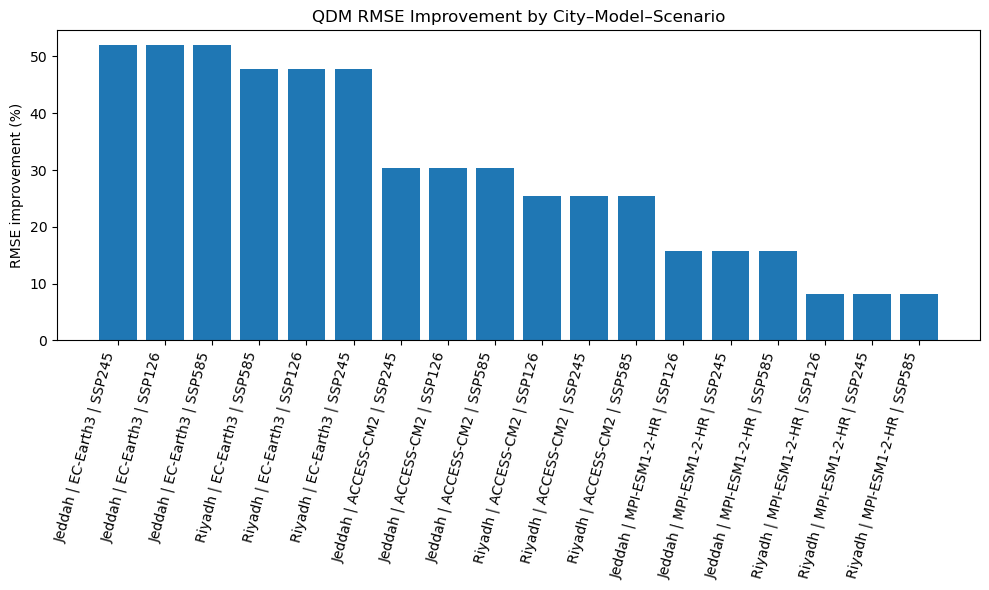

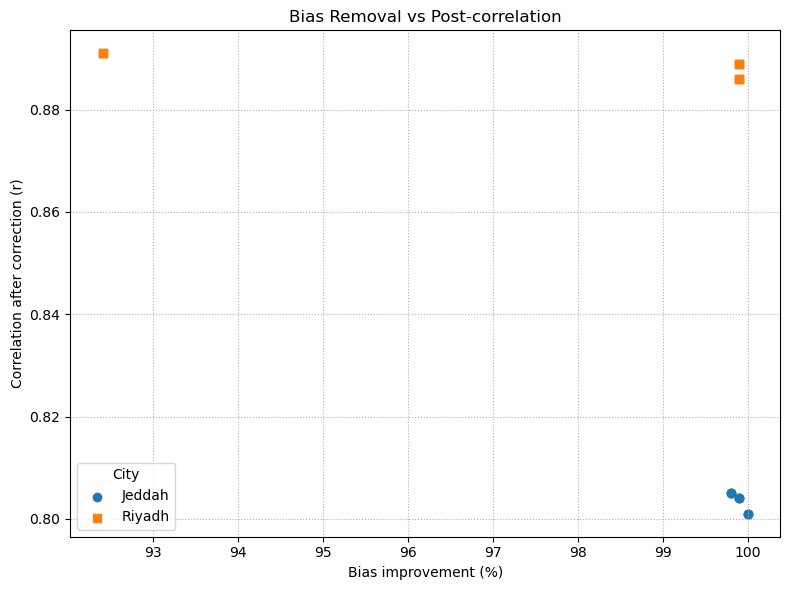

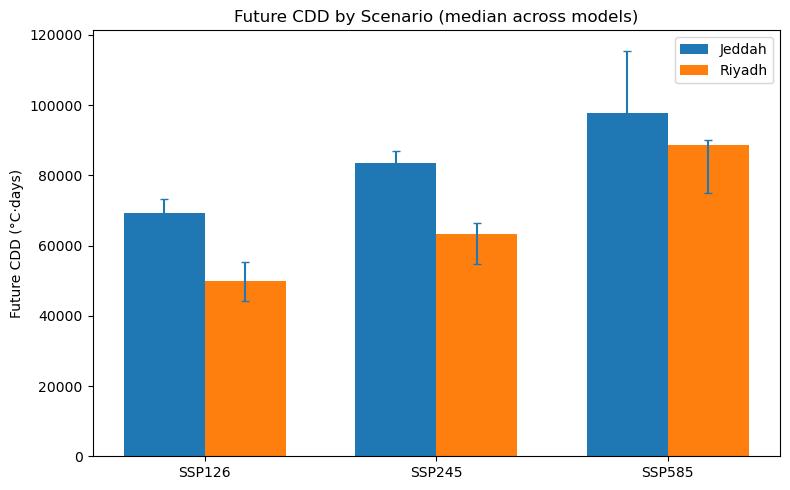

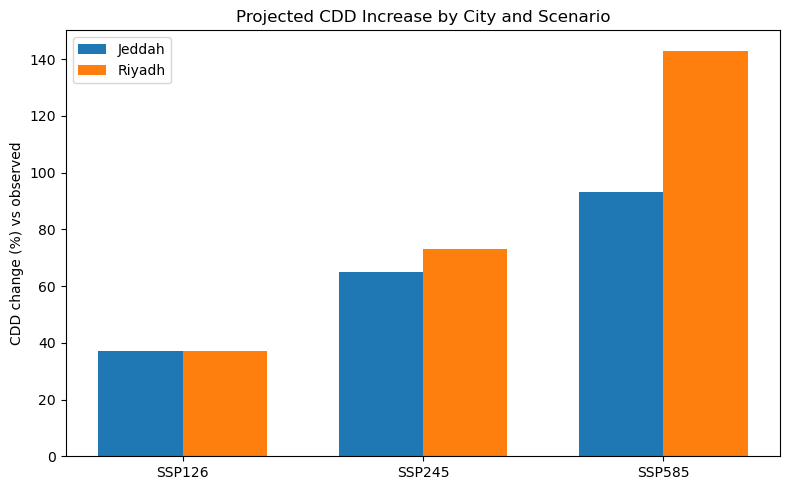

In [6]:
plot_rmse_improvement(summary_df)
plot_bias_corr(summary_df)
plot_cdd_by_scenario(summary_df)
plot_cdd_change_percent(summary_df)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Small helper to standardize month ticks
_MONTHS = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
def _xticks_months():
    plt.xticks(range(1,13), _MONTHS)

# ------------- A) Historical: ERA5 vs raw hist vs QDM-corrected -------------
def plot_historical_fit(results, city, model, scenarios=("ssp126","ssp245","ssp585"), save=None):
    """
    One panel per city+model: monthly means (1985–2014)
    ERA5 vs CMIP6 historical raw vs QDM-corrected (any scenario holds the same hist correction).
    """
    # grab any scenario present for this city+model
    sdict = results[city][model]
    scen = next(s for s in scenarios if s in sdict)  # first available
    mon = sdict[scen]["monthly"]

    plt.figure(figsize=(8.5,5))
    plt.plot(range(1,13), mon["obs"],            color="black", lw=2.5, label="ERA5 (1985–2014)")
    plt.plot(range(1,13), mon["hist_raw"],       linestyle="--", label="CMIP6 Hist (Raw)")
    plt.plot(range(1,13), mon["hist_corrected"], lw=2, label="CMIP6 Hist (QDM)")

    _xticks_months()
    plt.ylabel("Temperature (°C)")
    plt.title(f"{city.title()} — Historical Monthly Temperature\nModel: {model}")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    if save: plt.savefig(save, dpi=200, bbox_inches="tight")
    plt.show()

# ------------- B) Future: per-model Raw vs QDM across scenarios -------------
def plot_future_per_model(results, city, model, scenarios=("ssp126","ssp245","ssp585"), save=None):
    """
    Monthly means (2070–2100) for one city+model.
    Dashed = Raw future; Solid = QDM-corrected; Black = ERA5 reference.
    """
    # ERA5 from any scenario entry
    sdict = results[city][model]
    first = next(s for s in scenarios if s in sdict)
    mon_any = sdict[first]["monthly"]

    plt.figure(figsize=(9,5))
    plt.plot(range(1,13), mon_any["obs"], color="black", lw=2.5, label="ERA5 (1985–2014)")

    label_map = {"ssp126":"SSP1-2.6", "ssp245":"SSP2-4.5", "ssp585":"SSP5-8.5"}
    for scen in scenarios:
        if scen not in sdict: continue
        mon = sdict[scen]["monthly"]
        plt.plot(range(1,13), mon["future_raw"],       linestyle="--", alpha=0.7, label=f"{label_map[scen]} (Raw)")
        plt.plot(range(1,13), mon["future_corrected"], lw=2,              label=f"{label_map[scen]} (QDM)")

    _xticks_months()
    plt.ylabel("Temperature (°C)")
    plt.title(f"{city.title()} — Future Monthly Temperature (2070–2100)\nModel: {model}")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.legend(ncol=2)
    plt.tight_layout()
    if save: plt.savefig(save, dpi=200, bbox_inches="tight")
    plt.show()

# ------------- C) Future: multi-model mean (MMM) Raw vs QDM -------------
def plot_future_mmm(results, city, scenarios=("ssp126","ssp245","ssp585"), save=None):
    """
    Multi-model monthly means (MMM) for future 2070–2100.
    """
    # get ERA5 monthly from any available model/scenario
    any_model = next(iter(results[city]))
    any_scen  = next(iter(results[city][any_model]))
    obs_m = results[city][any_model][any_scen]["monthly"]["obs"]

    plt.figure(figsize=(9,5))
    plt.plot(range(1,13), obs_m, color="black", lw=2.5, label="ERA5 (1985–2014)")

    label_map = {"ssp126":"SSP1-2.6", "ssp245":"SSP2-4.5", "ssp585":"SSP5-8.5"}

    for scen in scenarios:
        raw_list, corr_list = [], []
        for model in results[city]:
            if scen not in results[city][model]: continue
            mon = results[city][model][scen]["monthly"]
            raw_list.append(mon["future_raw"])
            corr_list.append(mon["future_corrected"])
        if not raw_list: continue
        # MMM
        raw_mmm  = xr.concat(raw_list,  dim="model").mean("model")
        corr_mmm = xr.concat(corr_list, dim="model").mean("model")

        plt.plot(range(1,13), raw_mmm,  linestyle="--", alpha=0.8, label=f"{label_map[scen]} (Raw MMM)")
        plt.plot(range(1,13), corr_mmm, lw=2,               label=f"{label_map[scen]} (QDM MMM)")

    _xticks_months()
    plt.ylabel("Temperature (°C)")
    plt.title(f"{city.title()} — Future Monthly Temperature (2070–2100, Multi-Model Mean)")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.legend(ncol=2)
    plt.tight_layout()
    if save: plt.savefig(save, dpi=200, bbox_inches="tight")
    plt.show()

# ------------- D) Spread figure: raw vs QDM spaghetti for one scenario -------------
def plot_future_spread(results, city, scenario="ssp585", save=None):
    """
    Shows model spread (lines) for one scenario, raw vs QDM, plus MMM bold.
    """
    plt.figure(figsize=(9,5))

    # ERA5 monthly
    any_model = next(iter(results[city]))
    obs_m = results[city][any_model][scenario]["monthly"]["obs"] if scenario in results[city][any_model] \
            else results[city][any_model][next(iter(results[city][any_model]))]["monthly"]["obs"]
    plt.plot(range(1,13), obs_m, color="black", lw=2.5, label="ERA5 (1985–2014)")

    raw_list, corr_list = [], []
    for model in results[city]:
        if scenario not in results[city][model]: continue
        mon = results[city][model][scenario]["monthly"]
        raw_list.append(mon["future_raw"])
        corr_list.append(mon["future_corrected"])
        plt.plot(range(1,13), mon["future_raw"],       linestyle="--", alpha=0.4, color="tab:gray")
        plt.plot(range(1,13), mon["future_corrected"], alpha=0.7,                color="tab:blue")

    if raw_list:
        raw_mmm  = xr.concat(raw_list,  dim="model").mean("model")
        corr_mmm = xr.concat(corr_list, dim="model").mean("model")
        plt.plot(range(1,13), raw_mmm,  lw=2, linestyle="--", color="tab:gray", label="Raw MMM")
        plt.plot(range(1,13), corr_mmm, lw=2.5,             color="tab:blue",  label="QDM MMM")

    _xticks_months()
    plt.ylabel("Temperature (°C)")
    plt.title(f"{city.title()} — {scenario.upper()} Future Monthly Temperature (Model Spread)")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    if save: plt.savefig(save, dpi=200, bbox_inches="tight")
    plt.show()


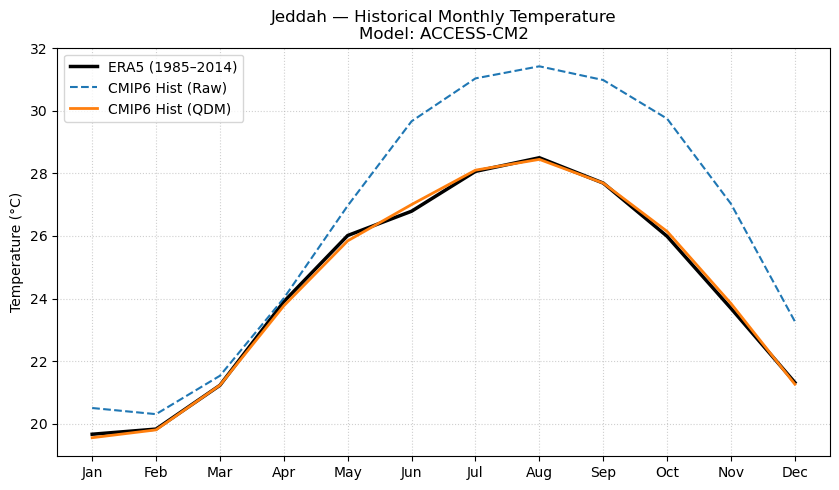

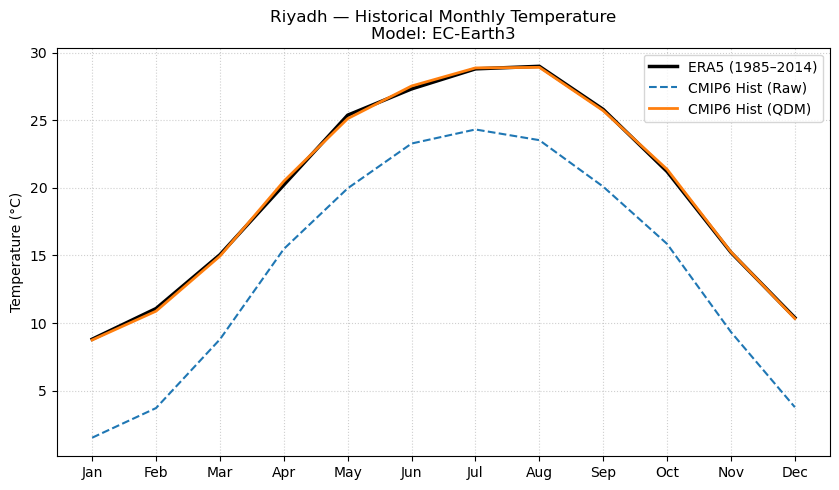

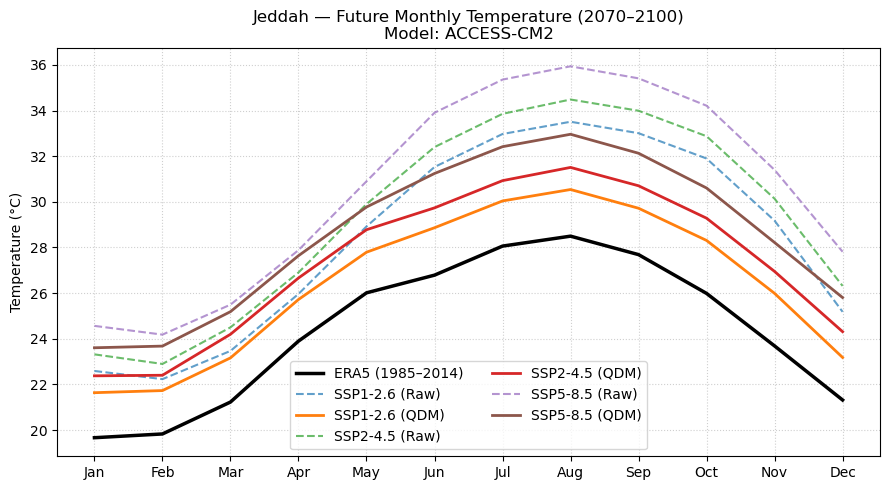

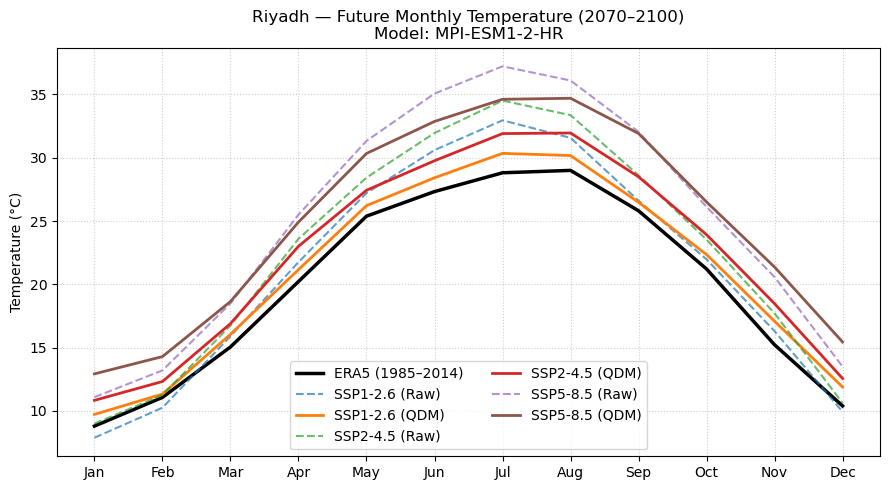

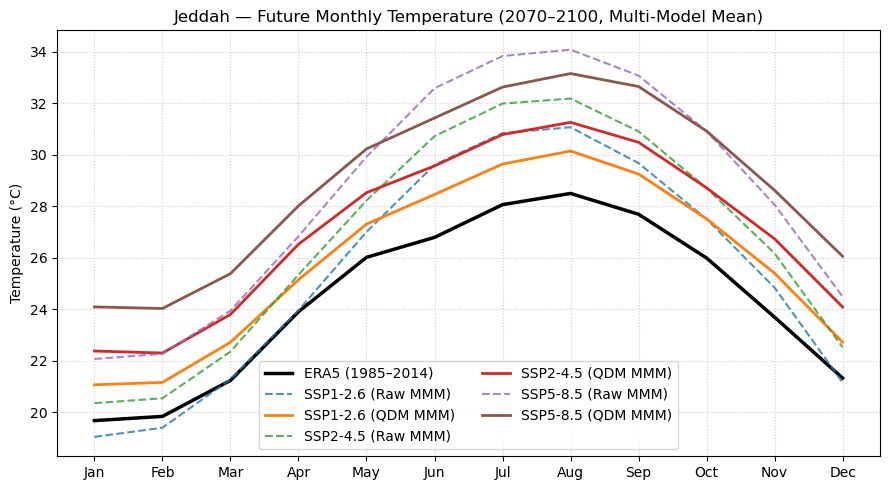

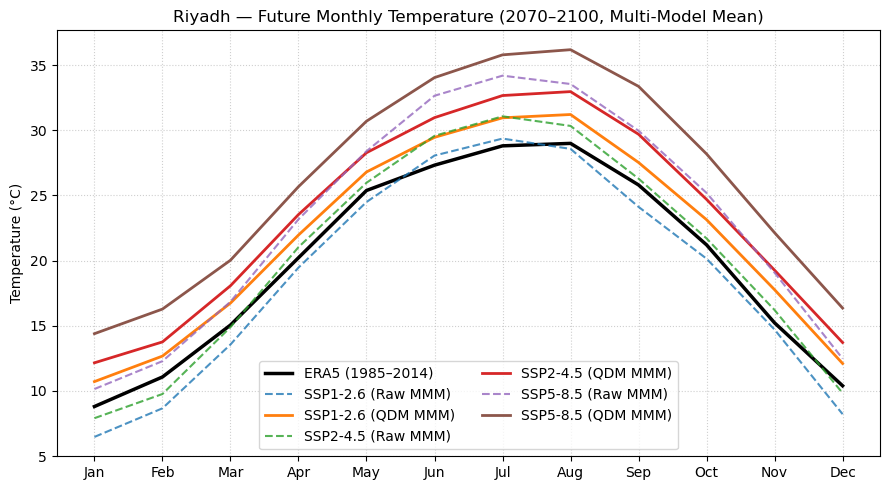

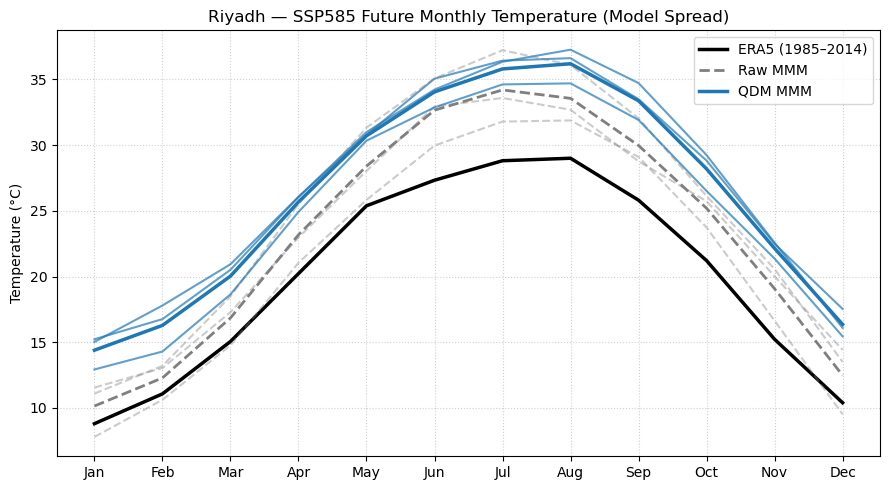

In [14]:
# Historical fit (per model)
plot_historical_fit(results, city="jeddah", model="ACCESS-CM2")
plot_historical_fit(results, city="riyadh", model="EC-Earth3")

# Future projections: per model
plot_future_per_model(results, city="jeddah", model="ACCESS-CM2")
plot_future_per_model(results, city="riyadh", model="MPI-ESM1-2-HR")

# Future projections: multi-model mean (matches your poster idea)
plot_future_mmm(results, city="jeddah")
plot_future_mmm(results, city="riyadh")

# Spread view for the high scenario
plot_future_spread(results, city="riyadh", scenario="ssp585")